In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Using dataset from txt file
data = pd.read_csv('googl.us.txt')
data

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


In [4]:
def get_index(date):
  for no, i in enumerate(data.Date):
    if i == date:
      index = no
  return index

In [5]:
# get index from training and testing period
train_start_index = get_index('2015-01-02')
train_end_index = get_index('2016-12-30')
test_start_index = get_index('2017-01-03')
test_end_index = get_index('2017-11-10')

train_set = data[train_start_index:train_end_index + 1]
test_set = data[test_start_index:test_end_index + 1]

In [6]:
print("Training sample size: ", len(train_set))
print("Testing sample size: ", len(test_set))

Training sample size:  504
Testing sample size:  218


In [12]:
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((test_close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, test_close[t], invest, initial_money)
                )
            # if action == 0, means hold
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [19]:
train_close = train_set.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = train_close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 268.445000.3, cost: 1.130862, total money: 10268.445000
epoch: 20, total rewards: 230.805000.3, cost: 0.656268, total money: 10230.805000
epoch: 30, total rewards: 165.715000.3, cost: 0.489243, total money: 10165.715000
epoch: 40, total rewards: 185.275000.3, cost: 0.308361, total money: 10185.275000
epoch: 50, total rewards: 159.955000.3, cost: 0.237924, total money: 10159.955000
epoch: 60, total rewards: 173.545000.3, cost: 0.338442, total money: 10173.545000
epoch: 70, total rewards: 281.815000.3, cost: 0.149701, total money: 10281.815000
epoch: 80, total rewards: 331.815000.3, cost: 0.118980, total money: 10331.815000
epoch: 90, total rewards: 415.255000.3, cost: 0.095489, total money: 10415.255000
epoch: 100, total rewards: 357.085000.3, cost: 0.079126, total money: 10357.085000
epoch: 110, total rewards: 411.115000.3, cost: 0.068216, total money: 10411.115000
epoch: 120, total rewards: 343.645000.3, cost: 0.058012, total money: 10343.645000
epoch: 130, t

In [20]:
test_close = test_set.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
test_agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = test_close, 
              skip = skip, 
              batch_size = batch_size)
states_buy, states_sell, total_gains, invest = test_agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 807.770000, total balance 9192.230000
day 3: buy 1 unit at price 825.210000, total balance 8367.020000
day 4: buy 1 unit at price 827.180000, total balance 7539.840000
day 5, sell 1 unit at price 826.010000, investment 2.258069 %, total balance 8365.850000,
day 6, sell 1 unit at price 829.860000, investment 0.563493 %, total balance 9195.710000,
day 7, sell 1 unit at price 829.530000, investment 0.284098 %, total balance 10025.240000,
day 10: buy 1 unit at price 829.020000, total balance 9196.220000
day 11: buy 1 unit at price 824.370000, total balance 8371.850000
day 12, sell 1 unit at price 828.170000, investment -0.102531 %, total balance 9200.020000,
day 13, sell 1 unit at price 844.430000, investment 2.433373 %, total balance 10044.450000,
day 23: buy 1 unit at price 821.620000, total balance 9222.830000
day 24: buy 1 unit at price 829.230000, total balance 8393.600000
day 27, sell 1 unit at price 834.850000, investment 1.610233 %, total balance 9228.450

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
save_data = pd.DataFrame({'states_buy' : states_buy,
                         'states_sell' : states_sell,
                         'total_gains' : total_gains,
                          'invest' : invest})

In [22]:
save_data

,states_buy,states_sell,total_gains,invest
0,1,5,400.075,4.00075
1,3,6,400.075,4.00075
2,4,7,400.075,4.00075
3,10,12,400.075,4.00075
4,11,13,400.075,4.00075
...,...,...,...,...
58,181,189,400.075,4.00075
59,185,190,400.075,4.00075
60,186,191,400.075,4.00075
61,187,192,400.075,4.00075


In [23]:
from google.colab import files
save_data.to_csv('DQN_stock_run2_save_data.csv') 
files.download('DQN_stock_run2_save_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

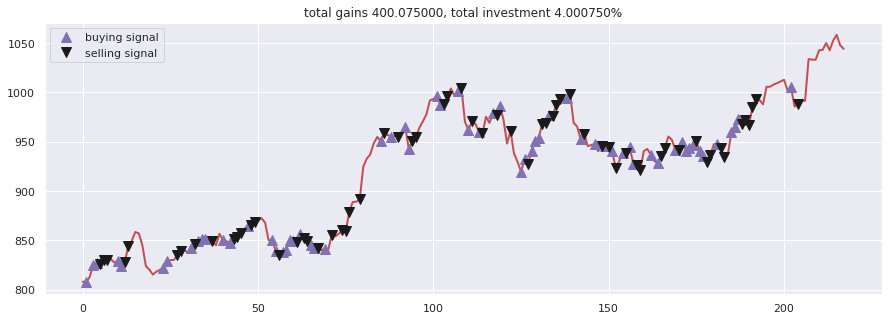

In [24]:
fig = plt.figure(figsize = (15,5))
plt.plot(test_close, color='r', lw=2.)
plt.plot(test_close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(test_close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()